In [2]:
import cv2
import torch
import random
import time
import numpy as np
import tensorrt as trt
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [12]:
w = '../onnxs/crowdhuman/crowd_640_32batch.trt'
device = torch.device('cuda:0')
img = cv2.imread('../inference/images_sample/image1.jpg')

In [13]:
# Infer TensorRT Engine
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())

bindings = OrderedDict()
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    print('@@@@@@@@@@@@@@@@',shape)
    # break
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

def postprocess(boxes,r,dwdh):
    dwdh = torch.tensor(dwdh*2).to(boxes.device)
    boxes -= dwdh
    boxes /= r
    return boxes

names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

[03/17/2023-16:39:57] [TRT] [I] The logger passed into createInferRuntime differs from one already provided for an existing builder, runtime, or refitter. Uses of the global logger, returned by nvinfer1::getLogger(), will return the existing value.
[03/17/2023-16:39:57] [TRT] [I] Loaded engine size: 136 MiB
[03/17/2023-16:39:58] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +8, now: CPU 5606, GPU 16352 (MiB)
[03/17/2023-16:39:58] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +1, GPU +10, now: CPU 5607, GPU 16362 (MiB)
[03/17/2023-16:39:58] [TRT] [W] TensorRT was linked against cuDNN 8.8.0 but loaded cuDNN 8.5.0
[03/17/2023-16:39:58] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +1, GPU +133, now: CPU 1, GPU 1191 (MiB)
@@@@@@@@@@@@@@@@ (32, 3, 640, 640)
@@@@@@@@@@@@@@@@ (32, 1)
@@@@@@@@@@@@@@@@ (32, 100, 4)
@@@@@@@@@@@@@@@@ (32, 100)
@@@@@@@@@@@@@@@@ (32, 100)
[03/17/2023-16:39:58] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +

/tmp/ipykernel_10532/3611856848.py:10: DeprecationWarning: Use get_tensor_name instead.
  name = model.get_binding_name(index)
/tmp/ipykernel_10532/3611856848.py:11: DeprecationWarning: Use get_tensor_dtype instead.
  dtype = trt.nptype(model.get_binding_dtype(index))
/tmp/ipykernel_10532/3611856848.py:12: DeprecationWarning: Use get_tensor_shape instead.
  shape = tuple(model.get_binding_shape(index))


In [14]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)

im.shape

(1, 3, 640, 640)

In [15]:
img2 = cv2.imread('../inference/images/hard_hat_workers1006_png.rf.d5a41dc617566d9e997231d36aa0332c.jpg')

img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
image2 = img2.copy()
image2, ratio2, dwdh2 = letterbox(image2, auto=False)
image2 = image2.transpose((2, 0, 1))
image2 = np.expand_dims(image2, 0)
image2 = np.ascontiguousarray(image2)

im2 = image2.astype(np.float32)

im2.shape

(1, 3, 640, 640)

In [16]:
im = np.concatenate([im] * 32,0)
im.shape

(32, 3, 640, 640)

In [17]:
im = torch.from_numpy(im).to(device)
im/=255
im.shape


torch.Size([32, 3, 640, 640])

In [18]:

# warmup for 10 times
start = time.perf_counter()

for _ in range(125):

    binding_addrs['images'] = int(im.data_ptr())
    context.execute_v2(list(binding_addrs.values()))
    # print(f'Cost {time.perf_counter()-start} s')

print(f'Cost {time.perf_counter()-start} s')
nums = bindings['num_dets'].data
boxes = bindings['det_boxes'].data
scores = bindings['det_scores'].data
classes = bindings['det_classes'].data
nums.shape,boxes.shape,scores.shape,classes.shape


Cost 3.1164173530014523 s


(torch.Size([32, 1]),
 torch.Size([32, 100, 4]),
 torch.Size([32, 100]),
 torch.Size([32, 100]))

In [32]:
start = time.perf_counter()

for _ in range(10000):

    binding_addrs['images'] = int(im.data_ptr())
    context.execute_v2(list(binding_addrs.values()))
    # print(f'Cost {time.perf_counter()-start} s')

print(f'Cost {time.perf_counter()-start} s')

Cost 5.819483205006691 s


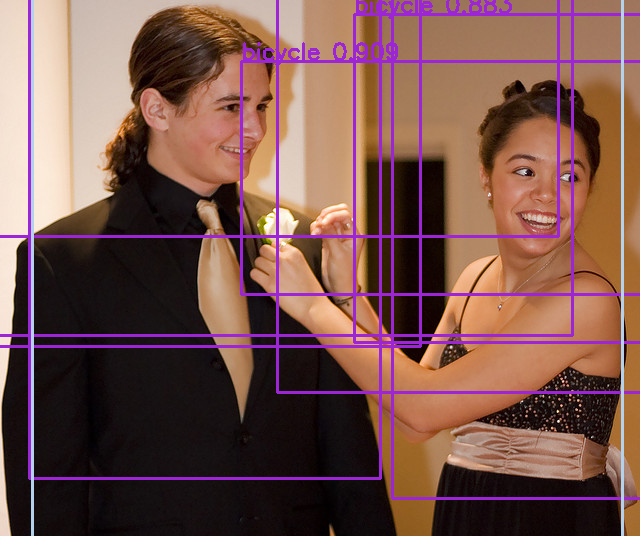

In [19]:
boxes1 = boxes[0,:nums[0][0]]
scores1 = scores[0,:nums[0][0]]
classes1 = classes[0,:nums[0][0]]

for box,score,cl in zip(boxes1,scores1,classes1):
    box = postprocess(box,ratio,dwdh).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img)

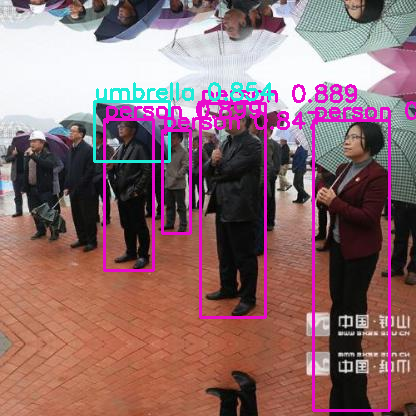

In [12]:
boxes2 = boxes[1,:nums[0][0]]
scores2 = scores[1,:nums[0][0]]
classes2 = classes[1,:nums[0][0]]

for box,score,cl in zip(boxes2,scores2,classes2):
    box = postprocess(box,ratio2,dwdh2).round().int()
    name = names[cl]
    color = colors[name]
    name += ' ' + str(round(float(score),3))
    cv2.rectangle(img2,box[:2].tolist(),box[2:].tolist(),color,2)
    cv2.putText(img2,name,(int(box[0]), int(box[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,color,thickness=2)

Image.fromarray(img2)

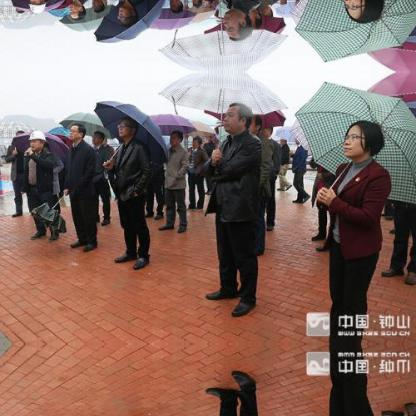